# UCI Introduction to Machine Learning
**Day 3: Graph Neural Networks**


Notebook adapted by Gage DeZoort from a similar notebook offered in his tutorial, [Graph Neural Networks for your Research](https://github.com/GageDeZoort/prc_gnn_tutorial/blob/main/gnn_tutorial.ipynb).



<a href="https://colab.research.google.com/github/GageDeZoort/intro_ml_uci/blob/main/day_3/intro_to_ML_day_3_gnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Software Installation
Just click through the following cells, no need to linger!

In [1]:
import os
import torch
import pandas as pd
import numpy as np
import networkx as nx
from matplotlib import pyplot as plt

# check the torch/cuda installations
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.8.0+cu126


Given the current PyTorch/Cuda installations, we'll install [PyTorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/) as follows:

In [2]:
# install PyTorch Geometric (PyG)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 23.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


**PyTorch Geometric (PyG)** is a high-level library for **graph deep learning** built on PyTorch.  
It provides data structures, layers, and utilities to build **GNNs** (Graph Neural Networks) for tasks like node/edge/graph classification, link prediction, and graph regression—at scale.

# 1. Graph-Structured Data

<p align="center">
  <img src="https://raw.githubusercontent.com/GageDeZoort/intro_ml_uci/main/day_3/images/graph.png" width="500">
</p>


A **graph** $G$ is a mathematical object consisting of a set of **nodes** (vertices) $V$ and their pairwise relationships encoded as **edges** $E$, i.e. $G=(V,E)$. In the following we will usually denote $|V|=n_\mathrm{nodes}$ and $|E|=n_\mathrm{edges}$.

Graphs can easily represent a wide range of structured data including **atoms in molecules** (nodes=atoms, edges=molecular bonds), **users in a social network** (nodes=people, edges=social connections), **cities and roads in a transportation system** (nodes=cities, edges=roads), **planetary simulations** (nodes=planets, edges=gravitational interactions), and more.

In PyG, graphs are stored as `Data` objects (see the [docs](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.Data.html#torch_geometric.data.Data)). Given a graph named `data`, we will find in many cases that it has several of the following attributes:

- `data.x`: node feature matrix of dimension $n_\mathrm{nodes}\times d_V$, where $d_V$ is the number of features attached to each node.
- `data.edge_index`: a sparse edge list in COO format indicating node indices at each end of each edge; this object has size $2\times n_\mathrm{edges}$.
- `data.edge_attr`: edge feature matrix of dimension $n_\mathrm{edges}\times d_E$, where $d_E$ is the number of features attached to each edges.
- `data.y`: training target with arbitary shape (remember, targets may be node-level, edge-level, or graph-level)

##  1.1 Karate Club
Let's take a look at an example graph in PyG. The Zachary Karate Club dataset (1977) is a social network describing friendships in a university karate club:
- 34 nodes (members of the karate club)
- 78 edges (friendships outside of the club)

A conflict arose between an instructor and an adminstrator, causing a faction in the club - half of the members formed a new karate club around the previous instructor and half either found a new instructor or quit karate.
- Truth labels: faction, 0 or 1 (per node)

Note that this is a single graph, and the goal is to perform *node classification* on the training set of nodes (a subset of all the nodes in the graph). In this way, Karate Club is used for semi-supervised node classification.

In [3]:
from torch_geometric.datasets import KarateClub

# KarateClub is a small, easily visualized community graph
karate_club = KarateClub()._data

> **Exercise 1.1a**: In the following cell, print the KarateClub object and its attributes, `x`, `edge_index`, `y`.

In [5]:
# EXERCISE

print(karate_club.x)
print(karate_club.edge_index)
print(karate_club.y)


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]])
tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8,

As a brief aside, let's take a look at how PyG stores edges. In a fully connected graph, there are $\frac{1}{2}n_\mathrm{nodes}(n_\mathrm{nodes}-1)$ edges. Sparse graphs have relatively few edges, i.e. $n_\mathrm{edges}\ll \frac{1}{2}n_\mathrm{nodes}(n_\mathrm{nodes}-1)$. Adjacency matrices aren't necessarily the best way to represent sparse graphs - instead, packages like PyG use edge index lists in COO format.

In [6]:
# edge lists (COO format)
out_nodes = karate_club.edge_index[0]
print('edges move out of the following nodes:\n', out_nodes)
in_nodes = karate_club.edge_index[1]
print('edges move into the following nodes:\n', in_nodes)

edges move out of the following nodes:
 tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
         3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
         7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
        13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
        21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
        27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
        31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33])
edges move into the following nodes:
 tensor([ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
         3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
         1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  

**Exercise 1.1b** Use `torch_geometric.utils.to_dense_adj` to generate an adjacency matrix from `edge_index`.

In [ ]:
# EXERCISE




We can print several additional details about the graph:

In [7]:
# more details about the graph
def get_graph_stats(data):
  print(f'Number of nodes: {data.num_nodes}')
  print(f'Number of edges: {data.num_edges}')
  print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
  print(f'Number of training nodes: {data.train_mask.sum()}')
  print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
  print(f'Has isolated nodes: {data.has_isolated_nodes()}')
  print(f'Has self-loops: {data.has_self_loops()}')
  print(f'Is undirected: {data.is_undirected()}')

get_graph_stats(karate_club)

Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Okay, good, we've taken a look at our first instance of `Data`. Now let's visualize the graph; note that here it has 4 truth labels instead of 2, which have been generated by a graph clustering algorithm (if you're interested see [this ref](https://ieeexplore.ieee.org/document/4358966), but it's not important here). We'll use `networkx`, a networks dynamics software package, to visualize the graph.

Truth labels tensor([1, 1, 1, 1, 3, 3, 3, 1, 0, 1, 3, 1, 1, 1, 0, 0, 3, 1, 0, 1, 0, 1, 0, 0,
        2, 2, 0, 0, 2, 0, 0, 2, 0, 0])


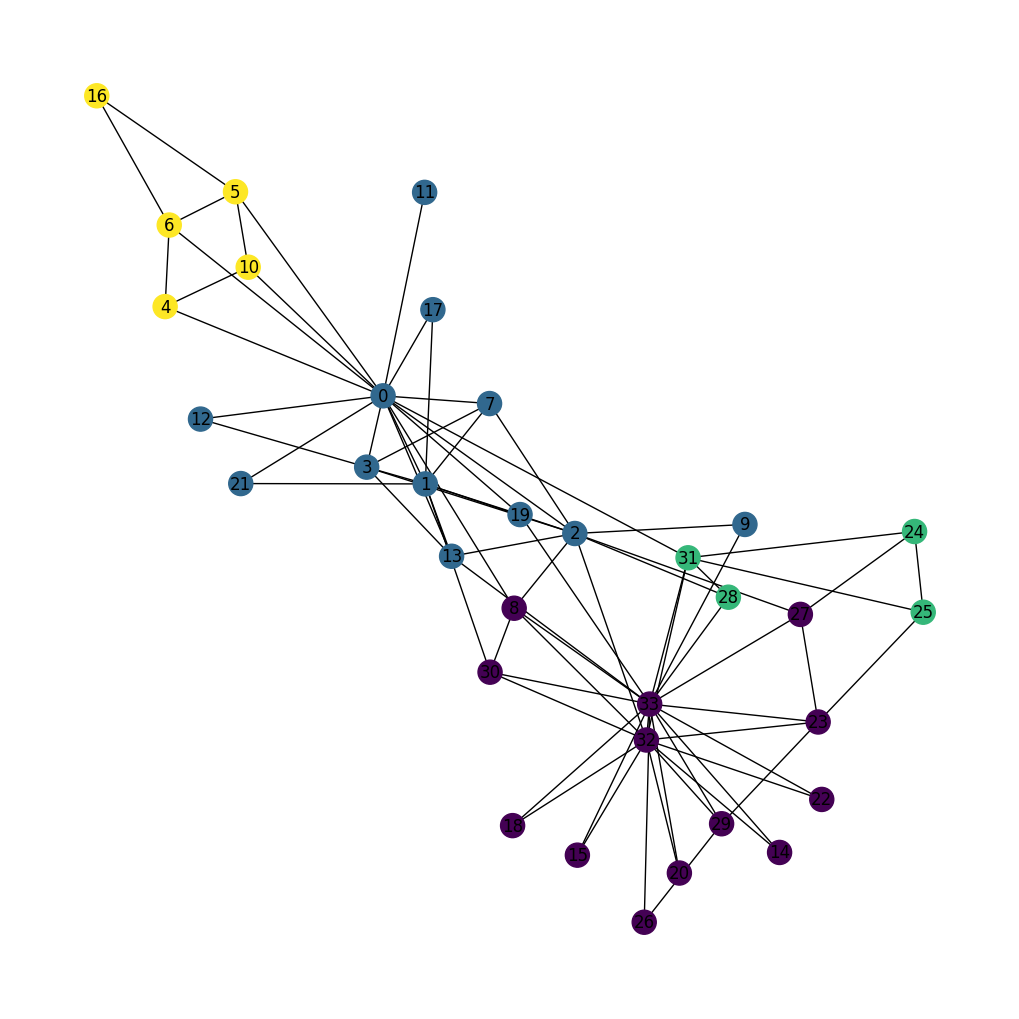

In [8]:
import torch_geometric
import networkx as networkx
print('Truth labels', karate_club.y)
karate_club_nx = torch_geometric.utils.to_networkx(karate_club, to_undirected=True)
plt.figure(figsize=(10,10))
nx.draw(karate_club_nx, with_labels=True, node_color=karate_club.y)

## 1.2 ENZYMES Graphs

Karate Club is used for semi-supervised node classification; let's look at a dataset used for graph-level classification. The [ENZYMES dataset](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.TUDataset.html#torch_geometric.datasets.TUDataset)
contains 600 graphs representing proteins with ~32.6 nodes (secondary structure elements - helices, turns or sheets) and ~124.3 edges (denoting neighbors in space or in the amino acid sequence) each. For expert details see the [TUDataset paper](https://arxiv.org/pdf/2007.08663.pdf). The goal is to assign each protein to one of 6 enzyme commission numbers, which describe the chemical reaction the enzyme catalyzes.

In [9]:
from torch_geometric.datasets import TUDataset
dataset = TUDataset(root='/tmp/TUDataset', name="ENZYMES", use_node_attr=True)
dataset.data

Processing...
Done!
/tmp/ipython-input-488298202.py:3: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  dataset.data


Data(x=[19580, 21], edge_index=[2, 74564], y=[600])

For PyG `datasets` containing multiple graphs, you'll typically want to use a `DataLoader` to load up batches of graphs:

In [10]:
from torch_geometric.loader import DataLoader

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
loader = DataLoader(dataset, batch_size=32, shuffle=False)
for batch in loader:
  print(batch)

DataBatch(edge_index=[2, 4264], x=[1069, 21], y=[32], batch=[1069], ptr=[33])
DataBatch(edge_index=[2, 3444], x=[972, 21], y=[32], batch=[972], ptr=[33])
DataBatch(edge_index=[2, 3848], x=[976, 21], y=[32], batch=[976], ptr=[33])
DataBatch(edge_index=[2, 4026], x=[1099, 21], y=[32], batch=[1099], ptr=[33])
DataBatch(edge_index=[2, 2560], x=[669, 21], y=[32], batch=[669], ptr=[33])
DataBatch(edge_index=[2, 4428], x=[1105, 21], y=[32], batch=[1105], ptr=[33])
DataBatch(edge_index=[2, 4434], x=[1145, 21], y=[32], batch=[1145], ptr=[33])
DataBatch(edge_index=[2, 3614], x=[911, 21], y=[32], batch=[911], ptr=[33])
DataBatch(edge_index=[2, 4144], x=[1096, 21], y=[32], batch=[1096], ptr=[33])
DataBatch(edge_index=[2, 5558], x=[1654, 21], y=[32], batch=[1654], ptr=[33])
DataBatch(edge_index=[2, 3538], x=[927, 21], y=[32], batch=[927], ptr=[33])
DataBatch(edge_index=[2, 3192], x=[845, 21], y=[32], batch=[845], ptr=[33])
DataBatch(edge_index=[2, 3582], x=[926, 21], y=[32], batch=[926], ptr=[33])


**Exercise 1.1c**: Notice also that the data batches appear to have concatenate the nodes and edges of all the graphs into a single "batch graph." How does this work? (Hint: look at the `batch` attribute appended to each batch.)

In [ ]:
# EXERCISE



# 2. Graph Neural Networks

In general, GNNs work by leveraging **local information** across the graph structure to intelligently compute new features for the nodes (and/or edges). A commonly used class of GNNs is the **Graph Convolutional Network (GCN)**. GCNs use more-or-less the same convolution operations you've seen used in CNNs; however, instead of applying them to patches of images, they apply them to node neighborhoods.

**Message** are computed from each of a node's neighbors, and these messages are passed back to the node and used to update its features. We're going to make this painfully concrete; first, here's a schematic:

![](https://drive.google.com/uc?id=1f5MJO9Kw1tWjJMBJBsZ-M4tMFz_dydr2)

## 2.1 Graph Convolutional NNs

Let’s look at the **Graph Convolutional Network (GCN)** as introduced in  
[Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/pdf/1609.02907.pdf).  
Don’t worry if the details look dense — we’ll highlight the main intuition.

The layer update rule is:

$$
\mathbf{x}_u^{(\ell + 1)} =
\sum_{v \in N(u) \cup \{v\}}
\frac{1}{c_{uv}} \, \mathbf{x}_v^{(\ell)} \mathbf{W}^{(\ell + 1)}
$$

---

#### 🔍 What this means
- In the $\ell^\mathrm{th}$ GNN layer, each node $v$ updates its representation $\mathbf{x}_v^{(\ell+1)}$ by aggregating the feature vectors of its **neighbors** (and itself).  
- $\mathbf{W}^{(\ell+1)}$ a matrix of learnable weights shared across all nodes in layer $\ell+1$.  
- $c_{uv}$ is a **normalization factor** ensuring that high-degree nodes don’t dominate the aggregation.  
  In the original GCN paper:
  $$
  c_{uv} = \sqrt{(deg(u)+1)(deg(v)+1)}
  $$

---

#### 🧩 Intuition
You can think of this operation as a **weighted average of the neighborhood features**:
- Each node “looks” at its neighbors,
- Scales their features by a normalization term,
- And mixes them through a shared linear transformation.

In matrix form, this corresponds to multiplying the node feature matrix $\mathbf{X}\in\mathbb{R}^{|V|\times N}$
by a normalized adjacency matrix $\tilde{\mathbf{A}}$ — a diffusion-like smoothing that blends information locally across the graph.


## 2.2 Cora (Karate Club but bigger!)

We will now use the [Cora dataset](https://relational.fit.cvut.cz/dataset/CORA) to predict the subject of a research paper given its words and citation network. The learning task is the same as it was with Karate Club, **semi-supervised node classification**. The Cora dataset consists of

- 2,708 nodes (scientific papers)
- 7 truth classes (paper subjects)
- 5,429 edges (representing citations)
- 1,433 node features (each a binary field indicating the presence of a word in the corresponding paper)

Let's go!

In [11]:
# import the cora citation network
from torch_geometric.datasets import Planetoid
cora_dataset = Planetoid(root='data/Planetoid', name='Cora')

Processing...
Done!


In [12]:
# there is only one graph in this dataset
cora = cora_dataset[0]
cora

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

**Exercise 2.2a** Print out the train, val, and test masks. How many nodes are we training with? How could this affect the prediction task?

In [ ]:
# EXERCISE



In [13]:
# use our previous function to inspect Cora
get_graph_stats(cora)

Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


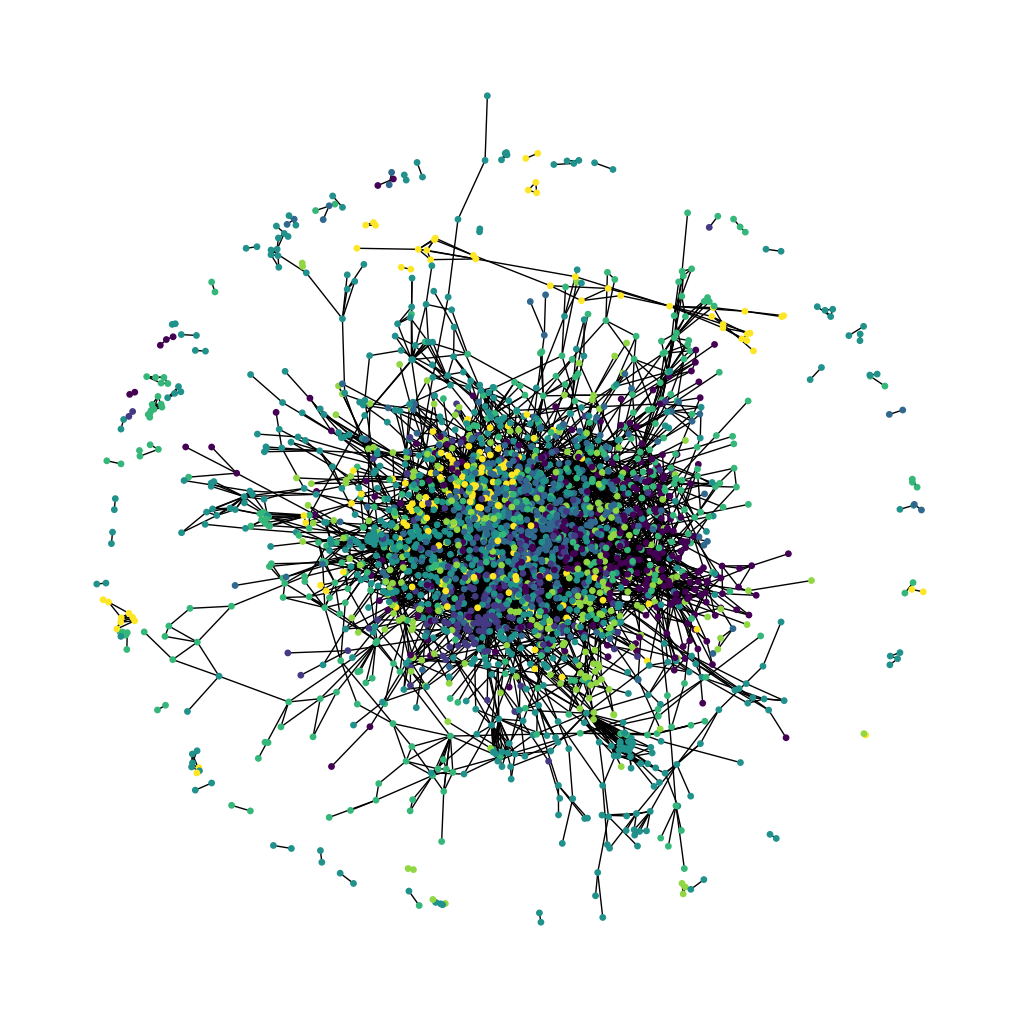

In [14]:
# let's visualize the graph
plt.figure(figsize=(10,10))
cora_nx = torch_geometric.utils.to_networkx(cora, to_undirected=True)
nx.draw(cora_nx, node_size=15, node_color=cora.y)

Okay, now it's time to set up a GCN using PyG! Reminder: we can construct a GNN in PyG similary to how we build a standard feed-forward neural network. We just need to swap the `torch.nn.Linear` layers with PyG's `GCNConv` implementing the graph convolution:

$$
\mathbf{x}_u^{(\ell + 1)} =
\sum_{v \in N(u) \cup \{v\}}
\frac{1}{c_{uv}} \, \mathbf{x}_v^{(\ell)} \mathbf{W}^{(\ell + 1)}
$$

In [15]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(cora_dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, cora_dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index) # apply first GCN convolution
        x = F.relu(x) # hidden graph embedding
        x = F.dropout(x, training=self.training) # randomly drop training nodes
        x = self.conv2(x, edge_index) # output graph embedding

        return x

This GCN is very similar to the [original implementation](https://github.com/tkipf/pygcn).

Let's take a look at the predictions of an untrained GCN by looking at a low dimensional representation:

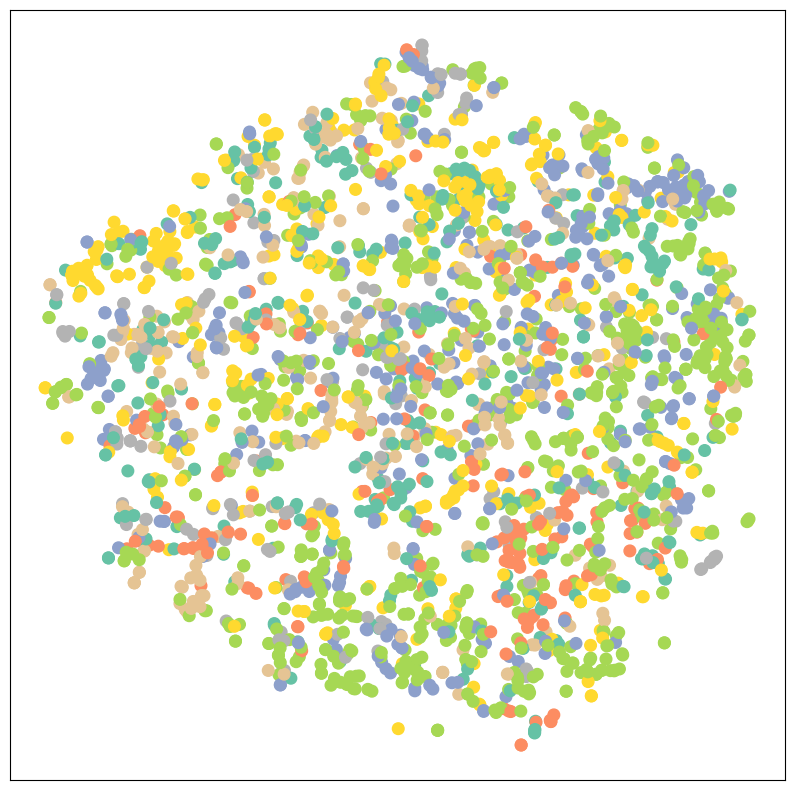

In [16]:
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# examine the output of an untrained GCN
model = GCN()
model.eval()
out = model(cora)
visualize(out, color=cora.y)

As an aside, we've used another dimensionality reduction technique called **t-SNE (t-Distributed Stochastic Neighbor Embedding)**. It creates a low-dimensional map that preserves *local relationships* in high-dimensional data, making clusters and structure visually interpretable.

This is as good a time as any to introduce the **Adam** optimizer.  

**Adam (Adaptive Moment Estimation)** is one of the most widely used optimization algorithms in deep learning.  
It combines the strengths of **Momentum** and **RMSProp** to adapt the learning rate for each parameter individually.

Each parameter is updated as:
$$
\theta_{t+1} = \theta_t - \eta \frac{\widehat{m}_t}{\sqrt{\widehat{v}_t} + \epsilon}
$$

---

- **Momentum ($m_t$)** → smooths updates by tracking an exponential moving average of past gradients  
- **Adaptive scaling ($v_t$)** → adjusts each parameter’s step size based on its gradient variance  
- Works reliably *out of the box*, especially in settings with noisy or sparse gradients.


In [19]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train(data):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(data):
      model.eval()
      out = model(data)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 101):
    loss = train(cora)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9481
Epoch: 002, Loss: 1.8552
Epoch: 003, Loss: 1.7480
Epoch: 004, Loss: 1.6065
Epoch: 005, Loss: 1.4412
Epoch: 006, Loss: 1.3347
Epoch: 007, Loss: 1.1756
Epoch: 008, Loss: 1.0644
Epoch: 009, Loss: 0.9755
Epoch: 010, Loss: 0.8180
Epoch: 011, Loss: 0.7493
Epoch: 012, Loss: 0.6556
Epoch: 013, Loss: 0.5857
Epoch: 014, Loss: 0.5013
Epoch: 015, Loss: 0.4289
Epoch: 016, Loss: 0.3989
Epoch: 017, Loss: 0.3460
Epoch: 018, Loss: 0.3054
Epoch: 019, Loss: 0.3189
Epoch: 020, Loss: 0.2199
Epoch: 021, Loss: 0.2260
Epoch: 022, Loss: 0.2202
Epoch: 023, Loss: 0.1668
Epoch: 024, Loss: 0.1909
Epoch: 025, Loss: 0.1365
Epoch: 026, Loss: 0.1390
Epoch: 027, Loss: 0.1507
Epoch: 028, Loss: 0.1233
Epoch: 029, Loss: 0.1181
Epoch: 030, Loss: 0.1272
Epoch: 031, Loss: 0.0860
Epoch: 032, Loss: 0.0724
Epoch: 033, Loss: 0.0731
Epoch: 034, Loss: 0.0756
Epoch: 035, Loss: 0.0862
Epoch: 036, Loss: 0.0584
Epoch: 037, Loss: 0.0853
Epoch: 038, Loss: 0.0736
Epoch: 039, Loss: 0.0880
Epoch: 040, Loss: 0.0535


In [20]:
test_acc = test(cora)
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7940


Not perfect, but it's pretty accurate at predicting paper subject area!

We can further verify that  by looking at the output embeddings of our **trained** model, which now produces a far better clustering of nodes of the same category.



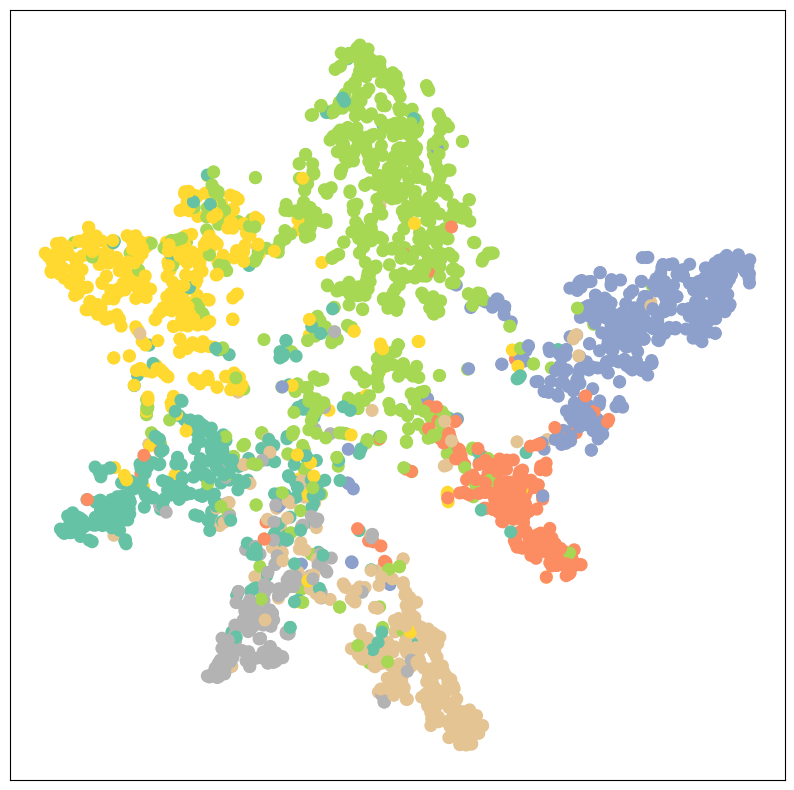

In [21]:
model.eval()

out = model(cora)
visualize(out, color=cora.y)

**Exercise 2.2b** Play around with the training loop above! Some guiding questions:

- How does GCN behave when increasing the hidden feature dimensionality or the number of layers? Does increasing the number of layers help at all?

- So far, we've just looked at GCNConv operations. You can try to use different GNN layers to see how model performance changes. What happens if you swap out all GCNConv instances with GATConv layers that make use of attention? Try to write a 2-layer GAT model that makes use of 8 attention heads in the first layer and 1 attention head in the second layer, uses a dropout ratio of 0.6 inside and outside each GATConv call, and uses a hidden_channels dimensions of 8 per head.

In [ ]:
# EXERCISE




In [ ]:
# EXERCISE




In [ ]:
# EXERCISE




## Solutions to Exercises

In [ ]:
# answers to exercises:

# Exercise 1.1a
# print(karate_club.x)
# print(karate_club.edge_index)
# print(karate_club.y)

# Exercise 1.1b
# A = torch_geometric.utils.to_dense_adj(karate_club.edge_index).squeeze()
#print('adjacency representation', A)

# Exercise 1.1c
# Batching in PyG works by concatenating nodes and creating a block diagonal adacency matrix.
# Membership is tracked through the `batch` attribute appended to each graph batch.
# See: https://pytorch-geometric.readthedocs.io/en/latest/advanced/batching.html

# Exercise 2.2a
# sum(cora.train_mask)
# There are 140 training nodes, 20 from each of the 7 truth classes.
# This means overtraining is a real possibility and regularization will be important.

# Exercise 2.2b
# Adding more layers doesn't help too much (and even hurts if the network becomes too deep)!
# This is because node features get "washed out" across the graph.

# Exercise 3a
# 21 input features, 6 output classes
# x = global_mean_pool(x, data.batch)

# Exercise 3b
# Just copy the train loop structure and the accuracy metric from the Cora train loop.
# But remember accuracy is computed per-graph now!